# 2. Feature Engineering with Transformers and NLTK

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature engineering and ML
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

# Visualization and display
import matplotlib.pyplot as plt
from tabulate import tabulate

# File handling
import os

# Download required NLTK data
nltk.download('punkt', quiet=True)    # Purpose: Sentence and word tokenization
nltk.download('stopwords', quiet=True) # Purpose: Common words filtering
nltk.download('wordnet', quiet=True)   # Purpose: Word lemmatization

True

In [2]:
# Check if we need to change working directory
current_dir = os.getcwd()
target_dir = os.path.dirname(current_dir)  # Get parent directory

if current_dir.endswith('notebooks'):  # Only change if we're in notebooks directory
    os.chdir('..')
    print(f"Changed working directory from {current_dir} to {os.getcwd()}")
else:
    print(f"Working directory already set to {current_dir}")

os.makedirs('data', exist_ok=True)  
os.makedirs('models', exist_ok=True) 

Changed working directory from c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial\notebooks to c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial


In [3]:
## 2. Load Data
print("Loading data...")
df = pd.read_pickle('data/processed_data.pkl')

Loading data...


### 1.Feature Types Selection: Categorizes Features 

#### Purpose:
- Categorizes features into text, categorical, numeric and boolean
- Guides subsequent processing steps
- Reduces manual feature type specification

#### Parameters:
- **unique_value_threshold**: int, default=10
  - Threshold for determining categorical vs text features.
  - **Lower values**: Treat more features as categorical
  - **Higher values**: Treat more features as text
  - **Why?** Features with many unique values are likely text, while those with few unique values are likely categorical.

#### Operations:
1. **Analyzes Each Feature's Data Type and Unique Values**:
   - Examines the data type and number of unique values for each feature.

2. **Categorizes Features into**:
   - **vectorize**: Text features needing TF-IDF
   - **onehot**: Categorical features needing one-hot encoding
   - **numeric**: Numerical features needing scaling

3. **Reports Feature Categorization**:
   - Outputs the categorization of features into text, categorical, and numeric.

In [4]:
## 3. Feature Types Selection
class FeatureTypeDetector:
    """Automatically detect and categorize features"""
    
    def __init__(self, unique_value_threshold=10, avg_length_threshold=60):
        self.unique_value_threshold = unique_value_threshold
        self.avg_length_threshold = avg_length_threshold
        self.feature_types = {}
    
    def categorize_features(self, df):
        table_data = []
        for column in df.columns:
            if column == 'fraudulent':  # Skip target variable
                continue
            
            # Drop missing values
            column_data = df[column].dropna()
            
            n_unique = column_data.nunique()
            avg_length = None
            
            if column_data.dtype == 'object':
                # Check if it's a text column (average length > XXX characters)
                avg_length = column_data.astype(str).str.len().mean()
                
                # Determine category
                if avg_length > self.avg_length_threshold or n_unique > self.unique_value_threshold:
                    category = 'vectorize'
                    self.feature_types['vectorize'] = self.feature_types.get('vectorize', []) + [column]
                else:
                    category = 'onehot'
                    self.feature_types['onehot'] = self.feature_types.get('onehot', []) + [column]
            else:
                if n_unique == 2:
                    category = 'boolean'
                    self.feature_types['boolean'] = self.feature_types.get('boolean', []) + [column]
                else:
                    category = 'numeric'
                    self.feature_types['numeric'] = self.feature_types.get('numeric', []) + [column]
            
            # Collect data for table
            table_data.append([column, avg_length, avg_length > self.avg_length_threshold if avg_length is not None else None, n_unique > self.unique_value_threshold, n_unique, category])
        
        # Sort table data by Category
        table_data = sorted(table_data, key=lambda x: x[5])
        
        # Print table
        print(tabulate(table_data, headers=["Column", "avg_length", "avg_length > threshold", "n_unique > threshold", "Unique values", "Category"]))
        
        print("\nFeature categorization:")
        for feat_type, columns in self.feature_types.items():
            print(f"\n{feat_type.capitalize()} features ({len(columns)}):")
            print(columns)
        
        return self.feature_types

# TEST
#detector = FeatureTypeDetector(unique_value_threshold=15, avg_length_threshold=60)
#feature_types = detector.categorize_features(df)
#print(feature_types)

### 2.FeatureProcessor: Processes Both Text and Categorical Features

#### Purpose:
- Standardizes and transforms text and categorical data for better feature extraction
- Removes noise and irrelevant information
- Reduces dimensionality of text data and encodes categorical data

#### Parameters:
- **feature_types**: dict
  - Specifies which columns to vectorize (text) and which to one-hot encode (categorical)
- **max_features**: int, default=30
  - Maximum number of features to keep for text vectorization
  - **Why?** Limits the size of the feature space
  - **Trade-off:** Might lose some less frequent but potentially important terms
- **min_df**: int, default=2
  - Minimum document frequency for terms in text vectorization
  - **Why?** Removes very rare terms that might not be informative
  - **Trade-off:** Might lose some rare but important terms

#### Operations:
1. **Text Preprocessing**:
   - Converts text to lowercase
   - Removes special characters
   - Tokenizes text into words
   - Removes stopwords
   - Lemmatizes words
   - Filters short words
   - Joins processed tokens back into text

2. **Text Vectorization**:
   - Applies TF-IDF vectorization to text features
   - Handles empty columns and reports vocabulary size

3. **Categorical Encoding**:
   - One-hot encodes categorical features
   - Replaces rare categories with 'Other'
   - Handles missing values

4. **Numeric Features**:
   - Adds numeric features to the transformed dataset

In [5]:
## 2. Text and Categorical Processor
class FeatureProcessor(BaseEstimator, TransformerMixin):
    """Process both text and categorical features"""
    
    def __init__(self, feature_types, max_features=30, min_df=2):
        self.feature_types = feature_types
        self.max_features = max_features
        self.min_df = min_df
        self.vectorizers = {}
        self.encoders = {}
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.empty_columns = []
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ''
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token.isalpha() and token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(tokens)
    
    def fit(self, X, y=None):
        # Process text features that need vectorization
        for column in self.feature_types.get('vectorize', []):
            print(f"Fitting vectorizer for {column}...")
            # Preprocess text
            processed_text = X[column].apply(self.preprocess_text)
            
            # Check if column has content after preprocessing
            if processed_text.str.strip().str.len().sum() == 0:
                print(f"Warning: {column} has no content after preprocessing")
                self.empty_columns.append(column)
                continue
            
            # Create and fit vectorizer with more lenient parameters
            self.vectorizers[column] = TfidfVectorizer(
                max_features=self.max_features,
                min_df=self.min_df,
                ngram_range=(1, 2),
                stop_words='english',
                strip_accents='unicode'
            )
            
            try:
                self.vectorizers[column].fit(processed_text)
                print(f"  Vocabulary size for {column}: {len(self.vectorizers[column].vocabulary_)}")
            except ValueError as e:
                print(f"Warning: Could not vectorize {column}: {str(e)}")
                self.empty_columns.append(column)
        
        # Process categorical features that need one-hot encoding
        for column in self.feature_types.get('onehot', []):
            print(f"Fitting encoder for {column}...")
            # Calculate value frequencies
            value_counts = X[column].value_counts(normalize=True)
            frequent_categories = value_counts[value_counts >= 0.01].index  # Keep categories with >= 1% frequency
            
            # Replace rare categories with 'Other'
            X_processed = X[column].copy()
            X_processed = X_processed.apply(lambda x: x if x in frequent_categories else 'Other')
            
            self.encoders[column] = OneHotEncoder(
                sparse_output=False,
                handle_unknown='ignore'
            )
            self.encoders[column].fit(X_processed.fillna('MISSING').values.reshape(-1, 1))
        
        return self
    
    def transform(self, X):
        X_transformed = pd.DataFrame(index=X.index)
        result_table = []
        
        # Transform text features
        for column in self.feature_types.get('vectorize', []):
            if column in self.empty_columns:
                continue
                
            processed_text = X[column].apply(self.preprocess_text)
            try:
                features = self.vectorizers[column].transform(processed_text).toarray()
                feature_names = [
                    f"{column}_tfidf_{feat}" 
                    for feat in self.vectorizers[column].get_feature_names_out()
                ]
                X_transformed = pd.concat([
                    X_transformed,
                    pd.DataFrame(features, columns=feature_names, index=X.index)
                ], axis=1)
                
                # Collect data for result table
                for feat in feature_names:
                    result_table.append([
                        feat, 'vectorize', X_transformed[feat].isna().sum(), X_transformed[feat].value_counts().head(3).to_dict()
                    ])
            except Exception as e:
                print(f"Warning: Error transforming {column}: {str(e)}")
        
        # Transform categorical features
        for column in self.feature_types.get('onehot', []):
            # Replace rare categories with 'Other'
            X_processed = X[column].copy()
            frequent_categories = set(self.encoders[column].get_feature_names_out([column]))
            X_processed = X_processed.apply(
                lambda x: x if f"{column}_{x}" in frequent_categories else 'Other'
            )
            
            features = self.encoders[column].transform(
                X_processed.fillna('MISSING').values.reshape(-1, 1)
            )
            feature_names = [
                f"{column}_{val}" for val in 
                self.encoders[column].get_feature_names_out([column])
            ]
            X_transformed = pd.concat([
                X_transformed,
                pd.DataFrame(features, columns=feature_names, index=X.index)
            ], axis=1)
            
            # Collect data for result table
            for feat in feature_names:
                result_table.append([
                    feat, 'onehot', X_transformed[feat].isna().sum(), X_transformed[feat].value_counts().head(3).to_dict()
                ])
        
        # Add numeric features
        numeric_columns = self.feature_types.get('numeric', [])
        if numeric_columns:
            X_transformed = pd.concat([
                X_transformed,
                X[numeric_columns]
            ], axis=1)
            
            # Collect data for result table
            for column in numeric_columns:
                result_table.append([
                    column, 'numeric', X_transformed[column].isna().sum(), X_transformed[column].value_counts().head(3).to_dict()
                ])
        
        # Add boolean features
        boolean_columns = self.feature_types.get('boolean', [])
        if boolean_columns:
            X_transformed = pd.concat([
                X_transformed,
                X[boolean_columns].fillna(0).astype(int)
            ], axis=1)
            
            # Collect data for result table
            for column in boolean_columns:
                result_table.append([
                    column, 'boolean', X_transformed[column].isna().sum(), X_transformed[column].value_counts().head(3).to_dict()
                ])
        
             
        # Print the result table
        print("\nResult Table:")
        print(tabulate(result_table, headers=["Column", "Category", "Missing Values", "Top 3 Values"]))
        
        return X_transformed

# TEST
#detector = FeatureProcessor(feature_types, max_features=30, min_df=2)
#X_transformed = detector.fit_transform(df)



### 4.FeatureScaler: Scales Numeric Features with Multiple Scaling Options

#### Purpose:
- Standardizes numeric features
- Provides multiple scaling methods
- Maintains feature interpretability

#### Parameters:
- **method**: str, default='robust'
  - Specifies the scaling method to use
  - **Options**: 'standard', 'minmax', 'robust', 'maxabs'
  - **Why?** Different scaling methods suit different data distributions
  - **Trade-off:** Choice of method affects the scaling and interpretability of features

#### Operations:
1. **Initialization**:
   - Initializes the scaler based on the specified method.
   - Raises a `ValueError` if the method is not one of the available options.

2. **Fitting**:
   - Identifies numeric columns in the dataset.
   - Fits the selected scaler to the numeric columns.
   - Reports scaling statistics based on the chosen method:
     - **StandardScaler**: Reports mean values and standard deviations.
     - **MinMaxScaler**: Reports minimum and maximum values.
     - **RobustScaler**: Reports center values (median) and scale values (IQR).

3. **Transforming**:
   - Copies the dataset.
   - Applies the fitted scaler to the numeric columns.
   - Reports scaled feature statistics.

In [6]:
## 3. Feature Scaler
class FeatureScaler(BaseEstimator, TransformerMixin):
    """
    Scale numeric features with multiple scaling options
    
    Purpose:
    - Standardizes numeric features
    - Provides multiple scaling methods
    - Maintains feature interpretability
    """
    def __init__(self, method='robust'):
        self.method = method
        self.numeric_columns = None
        
        # Dictionary of available scalers
        self.scalers = {
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
            'robust': RobustScaler(),
            'maxabs': MaxAbsScaler()
        }
        
        if method not in self.scalers:
            raise ValueError(f"Method must be one of {list(self.scalers.keys())}")
        
        self.scaler = self.scalers[method]
    
    def fit(self, X, y=None):
        # Identify numeric columns with more than 10 unique whole numbers
        self.numeric_columns = [
            col for col in X.select_dtypes(include=['int64', 'float64']).columns
            if X[col].nunique() > 10 and pd.api.types.is_integer_dtype(X[col])
        ]
        
        if len(self.numeric_columns) > 0:
            # Fit scaler
            self.scaler.fit(X[self.numeric_columns])
            
            # Report scaling statistics
            print(f"\nScaling Statistics ({self.method} scaling):")
            if self.method == 'standard':
                print("\nMean values:")
                print(pd.Series(self.scaler.mean_, index=self.numeric_columns))
                print("\nStandard deviations:")
                print(pd.Series(self.scaler.scale_, index=self.numeric_columns))
            elif self.method == 'minmax':
                print("\nMinimum values:")
                print(pd.Series(self.scaler.data_min_, index=self.numeric_columns))
                print("\nMaximum values:")
                print(pd.Series(self.scaler.data_max_, index=self.numeric_columns))
            elif self.method == 'robust':
                print("\nCenter values (median):")
                print(pd.Series(self.scaler.center_, index=self.numeric_columns))
                print("\nScale values (IQR):")
                print(pd.Series(self.scaler.scale_, index=self.numeric_columns))
        
        return self
    
    def transform(self, X):
        X_processed = X.copy()
        
        if len(self.numeric_columns) > 0:
            # Transform data
            X_processed[self.numeric_columns] = self.scaler.transform(X[self.numeric_columns])
            
            # Report transformation results
            print(f"\nScaled feature statistics:")
            print(X_processed[self.numeric_columns].describe())
            
            # Print table with scaled columns
            result_table = []
            for col in self.numeric_columns:
                result_table.append([
                    col, X[col].isna().sum(), X[col].nunique(), X[col].value_counts().head(3).to_dict()
                ])
            
            print("\nScaled Columns Table:")
            print(tabulate(result_table, headers=["Column", "Missing Values", "Unique Values", "Top 3 Values"]))
        
        return X_processed

# TEST
#scaler = FeatureScaler(method='robust')
#scaler.fit(X_transformed)
#X_scaled = scaler.transform(X_transformed)

### 5.FeatureCorrelationReducer: Removes Highly Correlated Features

#### Purpose:
- Identifies and removes highly correlated features
- Reduces multicollinearity in the dataset
- Prevents redundant information in the feature set

#### Parameters:
- **threshold**: float, default=0.95
  - Correlation coefficient threshold above which features are considered highly correlated
  - **Higher values**: More lenient, keeps more features
  - **Lower values**: More strict, removes more features
  - **Why?** Highly correlated features provide redundant information and can cause issues in some models

- **method**: str, default='pearson'
  - Method used to calculate correlation
  - Options include 'pearson', 'spearman', and 'kendall'
  - **Why?** Different correlation methods suit different types of relationships between variables

#### Operations:
1. **Correlation Matrix Calculation**:
   - Creates a correlation matrix using the specified method
   - Takes absolute values to consider both positive and negative correlations

2. **Feature Selection**:
   - Uses upper triangle of correlation matrix to avoid duplicate comparisons
   - Identifies features with correlations above the threshold
   - Maintains a list of features to keep and drop

3. **Reporting**:
   - Reports the number of removed features
   - Lists pairs of highly correlated features with their correlation coefficients
   - Helps understand which features were removed and why


In [7]:
## 4. New class to remove correlated features
class FeatureCorrelationReducer(BaseEstimator, TransformerMixin):
    """
    Remove highly correlated features based on correlation threshold
    
    Parameters:
    -----------
    threshold : float, default=0.95
        Correlation threshold above which features are considered highly correlated
    method : str, default='pearson'
        Correlation method to use
    """
    def __init__(self, threshold=0.95, method='pearson'):
        self.threshold = threshold
        self.method = method
        self.selected_features = None
        self.dropped_features = None
    
    def fit(self, X, y=None):
        # Calculate correlation matrix
        corr_matrix = pd.DataFrame(X).corr(method=self.method).abs()
        
        # Create upper triangle mask
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find features with correlation above threshold
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        
        # Get all feature names
        all_features = list(X.columns)
        
        # Keep features that are not in to_drop
        self.selected_features = [x for x in all_features if x not in to_drop]
        self.dropped_features = to_drop
        
        # Print correlation analysis results
        print("\nCorrelation Analysis Results:")
        print(f"Features removed due to high correlation: {len(to_drop)}")
        if len(to_drop) > 0:
            print("\nDropped features:")
            for f in to_drop:
                # Find highly correlated pairs
                corr_features = upper[f][upper[f] > self.threshold].index.tolist()
                for cf in corr_features:
                    print(f"- {f} correlated with {cf} (correlation: {corr_matrix.loc[f, cf]:.3f})")
        
        return self
    
    def transform(self, X):
        # Select only uncorrelated features
        X_transformed = X[self.selected_features]
        
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return self.selected_features

### 5.FeatureSelector: Selects Most Important Features

#### Purpose:
- Reduces dimensionality
- Selects most informative features
- Improves model efficiency

#### Parameters:
- **n_features**: int, default=100
  - Number of features to select
  - **Why?** Limits the number of features to the most informative ones
  - **Trade-off:** Might exclude some potentially useful features

#### Operations:
1. **Initialization**:
   - Initializes the selector with the specified number of features to select using `SelectKBest` with `mutual_info_classif` as the scoring function.
   - Measures the mutual information between each feature and the target variable. Mutual information is a non-negative value that measures the dependency between variables. A higher value indicates a higher dependency.
   - Suitable for both continuous and discrete features. (Other options: `chi2` for non-negative features and `f_classif` for continuous features using ANOVA)

2. **Fitting**:
   - Fits the selector to the data and target labels.
   - Identifies and stores the selected features.
   - Prints the feature importance scores and the top 10 most important features.

3. **Transforming**:
   - Transforms the dataset to include only the selected features.

In [8]:
## 5. Feature Selector
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Select most important features
    
    Purpose:
    - Reduces dimensionality
    - Selects most informative features
    - Improves model efficiency
    
    Parameters:
    -----------
    n_features : int, default=100
        Number of features to select
    """
    def __init__(self, n_features=100):
        self.n_features = n_features
        self.selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
        #(information gain) 
        self.selected_features = None
    
    def fit(self, X, y=None):
        # Select features
        self.selector.fit(X, y)
        self.selected_features = X.columns[self.selector.get_support()].tolist()
        
        # Print feature importance
        feature_scores = pd.DataFrame({
            'feature': X.columns,
            'score': self.selector.scores_
        }).sort_values('score', ascending=False)
        
        print(f"\nSelected {len(self.selected_features)} features")
        print("\nTop 10 most important features:")
        print(feature_scores.head(10))
        
        # Collect data for result table
        selected_table = feature_scores[feature_scores['feature'].isin(self.selected_features)]
        discarded_table = feature_scores[~feature_scores['feature'].isin(self.selected_features)]
        
        # Print the result tables
        print("\nSelected Features Table:")
        print(tabulate(selected_table, headers=["Feature", "Score"], tablefmt="grid"))
        
        print("\nDiscarded Features Table:")
        print(tabulate(discarded_table, headers=["Feature", "Score"], tablefmt="grid"))
        
        return self
    
    def transform(self, X):
        return X[self.selected_features]

    def get_feature_names_out(self, input_features=None):
        return self.selected_features



# TEST
#pipeline = Pipeline([
#   ('feature_selector', FeatureSelector(n_features=100))
#])
#y = df['fraudulent']
#X = df.drop('fraudulent', axis=1)
#pipeline.fit(X_scaled, y)
#X_selected = pipeline.named_steps['feature_selector'].transform(X_scaled)

#### 6. Feature Pipeline

The `create_feature_pipeline` function creates and runs a feature engineering pipeline:

- **Separate Target**: Separates the target variable `fraudulent` from the feature set.
- **Detect Feature Types**: Uses `FeatureTypeDetector` to categorize features.
- **Initialize Processors**: Initializes `FeatureProcessor`, `FeatureScaler`, `FeatureCorrelationReducer` and `FeatureSelector`.
- **Create the Pipeline**: Chains the processors into a scikit-learn `Pipeline`.
- **Fit and Transform the Data**: Fits and transforms the feature set `X` and target `y`.
- **Add Target Back**: Adds the target variable `fraudulent` back to the transformed feature set.
- **Return Final DataFrame**: Returns the final DataFrame with selected features and target variable.

#### 7. Feature Analysis

The `analyze_features` function analyzes the final feature set:

- **Feature Importance Plot**: Plots the top 20 feature correlations with the target variable `fraudulent`.
- **Distribution of Numeric Features**: Creates a boxplot to visualize the distribution of numeric features.

#### 8. Main Execution

The main execution block performs the following steps:

- **Process Features**: Calls `create_feature_pipeline` to process the features.
- **Analyze Features**: Calls `analyze_features` to analyze the final feature set.
- **Save Processed Data**: Saves the processed data to a pickle file.
- **Print Final Information**: Prints the number of features, feature types, and memory usage of the final feature set.
- **Completion Message**: Prints a message indicating that the feature engineering process is complete.

Starting feature engineering pipeline...
Detecting feature types...
Column                    avg_length    avg_length > threshold  n_unique > threshold      Unique values  Category
----------------------  ------------  ------------------------  ----------------------  ---------------  ----------
telecommuting                                                   False                                 2  boolean
has_company_logo                                                False                                 2  boolean
has_questions                                                   False                                 2  boolean
title_length                                                    True                                100  numeric
description_length                                              True                               3310  numeric
requirements_length                                             True                               2193  numeric
company_profile_length  

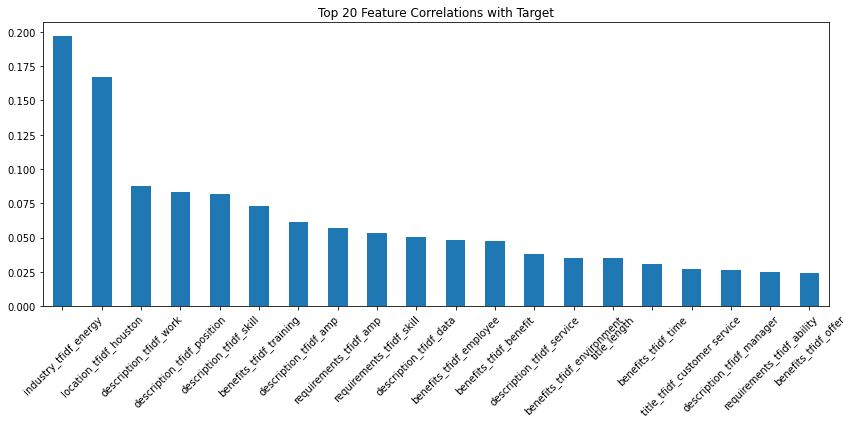

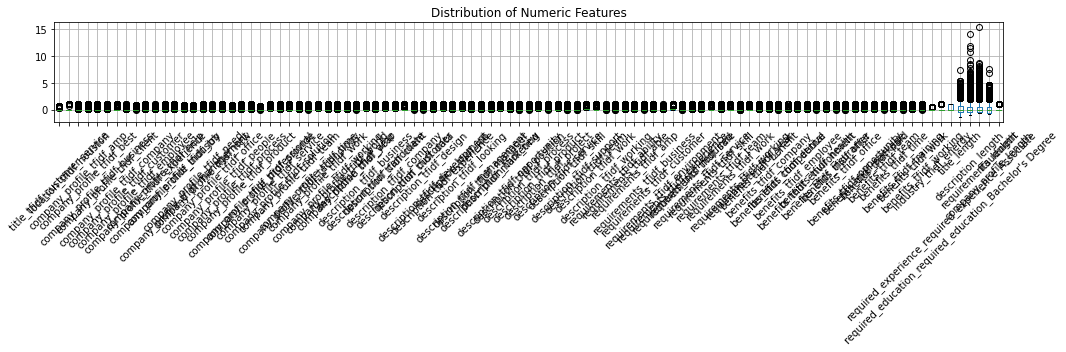


Saving processed data...

Final feature set information:
Number of features: 101

Feature types:
float64    98
int32       2
int64       1
dtype: int64

Memory usage: 13.6414794921875 MB

Feature engineering complete!


In [9]:
## 6. Feature Pipeline
def create_feature_pipeline(df):
    """Create and run the feature engineering pipeline"""
    
    # Separate target
    y = df['fraudulent']
    X = df.drop('fraudulent', axis=1)
    
    # Detect feature types
    print("Detecting feature types...")
    detector = FeatureTypeDetector(unique_value_threshold=40)
    feature_types = detector.categorize_features(X)
    
    # Initialize processors
    processor = FeatureProcessor(feature_types, max_features=30, min_df=2)
    scaler = FeatureScaler(method='robust')
    correlation_reducer = FeatureCorrelationReducer(threshold=0.90)
    selector = FeatureSelector(n_features=100)
    
    # Create the pipeline
    pipeline = Pipeline([
        ('feature_processor', processor),
        ('feature_scaler', scaler),
        ('correlation_reducer', correlation_reducer),
        ('feature_selector', selector)
    ])
    
    # Fit and transform the data
    print("\nProcessing features...")
    X_final = pipeline.fit_transform(X, y)
    
    # Add target back
    X_final = pd.DataFrame(X_final, columns=pipeline.named_steps['feature_selector'].get_feature_names_out())
    X_final['fraudulent'] = y.values
    
    print(f"\nFinal feature count: {X_final.shape[1]}")
    
    return X_final

## 7. Feature Analysis
def analyze_features(df_processed):
    """Analyze final feature set"""
    
    # Feature importance plot
    plt.figure(figsize=(12, 6))
    feature_importance = df_processed.corr()['fraudulent'].sort_values(ascending=False)
    feature_importance.drop('fraudulent').head(20).plot(kind='bar')
    plt.title('Top 20 Feature Correlations with Target')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Distribution of numeric features
    numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(15, 5))
    df_processed[numeric_cols].boxplot()
    plt.xticks(rotation=45)
    plt.title('Distribution of Numeric Features')
    plt.tight_layout()
    plt.show()

## 8. Main Execution
if __name__ == "__main__":
    # Process features
    print("Starting feature engineering pipeline...")
    df_processed = create_feature_pipeline(df)
    
    # Analyze features
    print("\nAnalyzing final feature set...")
    analyze_features(df_processed)
    
    # Save processed data
    print("\nSaving processed data...")
    df_processed.to_pickle('data/engineered_features.pkl')
    
    # Print final information
    print("\nFinal feature set information:")
    print(f"Number of features: {df_processed.shape[1]}")
    print("\nFeature types:")
    print(df_processed.dtypes.value_counts())
    print("\nMemory usage:", df_processed.memory_usage().sum() / 1024 / 1024, "MB")
    
    print("\nFeature engineering complete!")